# **Summary**

## Instalasi dan import library

Menginstal library yang dibutuhkan untuk proses crawling, pengolahan teks, dan analisis jaringan.

In [ ]:
!pip install networkx matplotlib nltk Sastrawi tqdm pandas sklearn requests beautifulsoup4

  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl.metadata (909 bytes)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Import library

In [ ]:
!pip install Sastrawi # Install the correct package

import numpy as np
import pandas as pd
import requests
import re
import networkx as nx

from urllib.request import urlopen
from bs4 import BeautifulSoup

from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize , word_tokenize
from nltk.corpus import stopwords
# Import from the correct package and module
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Crawling artikel

Mengambil konten artikel dari URL menggunakan BeautifulSoup.

In [ ]:
def crawl_article(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Memastikan permintaan berhasil
        soup = BeautifulSoup(response.content, 'html.parser')

        # Mengambil judul
        title_element = soup.find('h1', class_='jeg_post_title')
        title = title_element.get_text(strip=True) if title_element else 'Judul tidak ditemukan'

        # Mengambil Isi
        content_div = soup.find('div', class_='content-inner')
        if content_div:
            paragraphs = content_div.find_all('p')
            content = "\n".join(p.get_text(strip=True) for p in paragraphs)
        else:
            content = 'Isi artikel tidak ditemukan'

        # Mengambil tanggal
        date_div = soup.find('div', class_='jeg_meta_date')
        date_text = date_div.find('a').get_text(strip=True) if date_div else 'Tanggal tidak ditemukan'

        # Mengambil kategori
        category_meta = soup.find('span', class_='breadcrumb_last_link')
        if category_meta:
            category_link = category_meta.find('a')
            category = category_link.get_text(strip=True) if category_link else 'Kategori tidak ditemukan'
        else:
            category = 'Kategori tidak ditemukan'

        return {'Judul': title, 'Isi': content, 'Tanggal': date_text, 'Kategori': category}

    except requests.RequestException as e:
        print(f"Error fetching article: {e}")
        return None

article_url = input("Masukkan URL artikel: ")

# Melakukan crawl pada satu artikel
article = crawl_article(article_url)

# Membuat DataFrame dari dictionary
if article:
    df = pd.DataFrame([article])
    print(df)
else:
    print("Gagal mengambil artikel.")

Masukkan URL artikel: https://mojok.co/liputan/kuliner/warung-pecel-cepu-blora-dirindukan-di-amerika-dan-rusia/
                                               Judul  \
0  Kisah Patah Hati di Warung Pecel Cepu Blora, R...   

                                                 Isi         Tanggal Kategori  
0  Tugas lapangan di Cepu, Blora, membawa saya pa...  9 Oktober 2024  Kuliner  


## Preprosesing teks

mengubah teks menjadi huruf kecil

In [ ]:
# Fungsi untuk mengubah teks menjadi huruf kecil
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

df['lower case'] = df['Isi'].apply(clean_lower)
df['lower case']

,lower case
0,"tugas lapangan di cepu, blora, membawa saya pa..."


Membersihkan tanda baca dan angka

In [ ]:
# Fungsi untuk membersihkan tanda baca dan angka (menghapus koma)
def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z .]+')  # Koma dihilangkan dari pengecualian
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

df['tanda baca'] = df['lower case'].apply(clean_punct)
df['tanda baca']

,tanda baca
0,tugas lapangan di cepu blora membawa saya pada...


Normalisasi spasi

In [ ]:
# Fungsi untuk normalisasi spasi
def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

df['spasi'] = df['tanda baca'].apply(_normalize_whitespace)
df['spasi']

,spasi
0,tugas lapangan di cepu blora membawa saya pada...


Tokenisasi kata

In [ ]:
# Tokenisasi
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return text

df['token'] = df['spasi'].apply(tokenize_text)
df['token']

,token
0,"[tugas, lapangan, di, cepu, blora, membawa, sa..."


Pembersihan stopwords

In [ ]:
# Pembersihan stopwords setelah tokenisasi
def clean_stopwords(tokens):
    if isinstance(tokens, list):
        stopword = set(stopwords.words('indonesian'))
        filtered_tokens = [word for word in tokens if word not in stopword]
        return filtered_tokens
    return tokens

df['stopwords'] = df['token'].apply(clean_stopwords)
df['stopwords']

,stopwords
0,"[tugas, lapangan, cepu, blora, membawa, warung..."


Gabungkan kembali token menjadi string

In [ ]:
# Gabungkan kembali token menjadi string
df['processed_text'] = df['stopwords'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

prep_result = df['processed_text'].to_dict()
print(prep_result)

{0: 'tugas lapangan cepu blora membawa warung pecel legendaris . namanya warung pecel sunti lokasinya jl . st. kota . warung kerap mengirim bumbu amerika rusia . . wib suasana warung pecel sunti berjejal pembeli kamis . masuk . antre pembeli pembeli memilih membungkus . orang laki laki berseragam kerja pekerja pertambangan minyak cepu blora makan . telas napa mboten bu habis nggak bu nasi boran tinggal mencoba . tenang mas paruh baya bernama tatik meladeni pembeli pembeli antre . tatik grapyak pembeli . jarang melempargojlokanke berujung salinggojlokdan gelak tawa . teman teman konten konten lek damis ya sosok tatik . orang cepu kaget mengiranya jutek . giliran . pengelola warung pecel sunti cepu blora menyodorkan sepiring nasi pecel lauk telur tempe . diguyur lodeh nggak mas . tawari barang kali masnya nggak cocok tawar tatik . mengangguk salahnya . dasarnya makan . halal kenyang . lantas meraih piring mengguyurnya sayur lodeh . pecelnya gurih manis . lokasi warung pecel suntiberada p

melakukan tokenisasi kalimat pada dua teks: satu dari teks yang telah diproses dan satu dari teks asli.

In [ ]:
kalimat_preprocessing = nltk.sent_tokenize(prep_result[0])
kalimat = nltk.sent_tokenize(df['Isi'][0])

## TF-IDF dan cosine similitary

Hitung tf-udf

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)
terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_preprocessing.toarray(), columns=terms)
tfidf_preprocessing

,adik,adiknya,ahmad,ajari,alhasil,aly,amerika,anak,anaknya,angin,...,ular,untungsampeyan,upn,veteran,wajar,warung,wib,wujudnya,ya,yogyakarta
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.240209,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.266230,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.442255,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.255241,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
93,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.263052,0.0,0.000000,0.0,0.0
94,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.424605,0.0,0.000000,0.0,0.0
95,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


Menghitung cosine similitary

In [ ]:
cossim_prep = cosine_similarity(tfidf_preprocessing, tfidf_preprocessing)

similarity_matrix = pd.DataFrame(cossim_prep,
								 index=range(len(kalimat_preprocessing)),
								 columns=range(len(kalimat_preprocessing)))

similarity_matrix

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,1.000000,0.130460,0.0,0.061311,0.0,0.117477,0.0,0.0,0.107085,0.000000,...,0.044663,0.0,0.0,0.0,0.053804,0.000000,0.418469,0.208069,0.000000,0.0
1,0.130460,1.000000,0.0,0.067953,0.0,0.217031,0.0,0.0,0.000000,0.000000,...,0.049501,0.0,0.0,0.0,0.000000,0.000000,0.142867,0.384394,0.000000,0.0
2,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.061311,0.067953,0.0,1.000000,0.0,0.061190,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.067142,0.108377,0.000000,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.069166,0.000000,0.093972,0.0
93,0.418469,0.142867,0.0,0.067142,0.0,0.128648,0.0,0.0,0.117269,0.000000,...,0.048910,0.0,0.0,0.0,0.058920,0.069166,1.000000,0.227855,0.064881,0.0
94,0.208069,0.384394,0.0,0.108377,0.0,0.346139,0.0,0.0,0.000000,0.000000,...,0.078948,0.0,0.0,0.0,0.000000,0.000000,0.227855,1.000000,0.000000,0.0
95,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.093972,0.064881,0.000000,1.000000,0.0


## Graf dan analisis centrality

Membangun graf berdasarkan similitary dan visualisasi graf

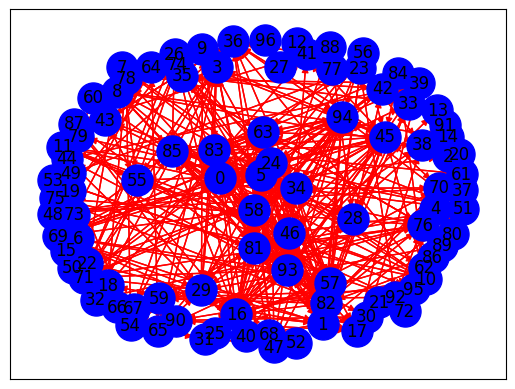

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G_preprocessing = nx.DiGraph()
for i in range(len(cossim_prep)):
    G_preprocessing.add_node(i)

for i in range(len(cossim_prep)):
    for j in range(len(cossim_prep)):
        similarity_preprocessing = cossim_prep[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

pos = nx.spring_layout(G_preprocessing, k=2)
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

plt.show() # Now plt is defined and the show() function can be called

menghitung closeness centrality

In [ ]:
closeness_preprocessing = nx.closeness_centrality(G_preprocessing)

sorted_closeness_preprocessing = sorted(closeness_preprocessing.items(), key=lambda x: x[1], reverse=True)
print("Closeness Centrality:")
for node, closeness in sorted_closeness_preprocessing:
    print(f"Node {node}: {closeness:.4f}")

Closeness Centrality:
Node 94: 0.4542
Node 81: 0.4485
Node 5: 0.4430
Node 63: 0.4430
Node 45: 0.4349
Node 16: 0.4323
Node 82: 0.4323
Node 93: 0.4323
Node 85: 0.4271
Node 24: 0.4172
Node 34: 0.4172
Node 0: 0.4148
Node 58: 0.4077
Node 1: 0.4054
Node 57: 0.4031
Node 69: 0.3987
Node 83: 0.3900
Node 29: 0.3817
Node 71: 0.3817
Node 26: 0.3777
Node 36: 0.3777
Node 46: 0.3738
Node 65: 0.3718
Node 76: 0.3718
Node 3: 0.3643
Node 10: 0.3624
Node 51: 0.3588
Node 11: 0.3552
Node 67: 0.3467
Node 41: 0.3450
Node 47: 0.3434
Node 56: 0.3417
Node 75: 0.3417
Node 8: 0.3385
Node 87: 0.3385
Node 7: 0.3353
Node 70: 0.3322
Node 43: 0.3292
Node 55: 0.3292
Node 84: 0.3292
Node 54: 0.3247
Node 28: 0.3218
Node 33: 0.3204
Node 53: 0.3204
Node 59: 0.3175
Node 22: 0.3161
Node 64: 0.3161
Node 38: 0.3134
Node 61: 0.3134
Node 62: 0.3134
Node 17: 0.3120
Node 39: 0.3067
Node 88: 0.3028
Node 35: 0.3015
Node 42: 0.3015
Node 32: 0.3003
Node 23: 0.2990
Node 30: 0.2965
Node 92: 0.2953
Node 79: 0.2941
Node 9: 0.2917
Node 40: 

Menampilkan ringkasan berdasarkan centrality

In [ ]:
ringkasan_closeness_preprocessing = ""
print("Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:")
for node, closeness_preprocessing in sorted_closeness_preprocessing[:3]:
    top_sentence = kalimat[node]
    ringkasan_closeness_preprocessing += top_sentence + " "
    print(f"Node {node}: Closeness Centrality = {closeness_preprocessing:.4f}")
    print(f"Kalimat: {top_sentence}\n")

Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:
Node 94: Closeness Centrality = 0.4542
Kalimat: Penulis: Muchamad Aly RezaEditor: Ahmad Effendi
BACA JUGA:Pengalaman Pertama Saya Mencoba Kuliner Ekstrem di Jogja, Rasa Tongseng Ular Tak Semenyeramkan Wujudnya
Ikuti artikel dan berita Mojok lainnya diGoogle News
Terakhir diperbarui pada 9 Oktober 2024 olehMuchamad Aly Reza

Node 81: Closeness Centrality = 0.4485
Kalimat: “Saya sudah ajari adik saya membuat bumbu pecelnya, misalnya nanti dia akan neruskan warung ini,” tutur Tatik.

Node 5: Closeness Centrality = 0.4430
Kalimat: Saya baru bisa masuk tak lama kemudian.

